### Introduction

 Lending Club is a US peer-to-peer lending company that provides a largest peer-to-peer online lending platform. The Lending Club’s platform enables borrowers to obtain a loan funded by investors. Investors profit from interest payments on loans. Based on the levels of loans' default rate, Lending categorizes the quality of the loans into seven grades, each of which assigned with different interest rates and risks. From the investors' point of view, they want to find out the potential default rate of each specific loans, in order to avoid investing on those loans with high risk of default.

**Goal of this project is to build a predictive model to predict the default rate of the newly issued loans, based on information from historic loans.**

The model is trained on data of 2015 year and tested on data from 2016 year.
Data cleaning are performed to uniform the features used in the training set and the target set. Categorical variables are extracted into meaningful features for model input via feature engineering. XGBoost is used as the modeling algorithm. As a advanced Gradient Boosted Regression Trees (GBRT) algorithm, XGBoost adopted several advantages of GBRT such as: natural handling of data of mixed type , predictive power, robustness to outliers in output space (via robust loss functions). Combining both Random Forest and Adaptive Gradent Boosting algorithms, XGBoost exhibited high efficiency and flexibility in modeling large datasets with ease of implementation.

## Import Libraries

In [235]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
pd.set_option('display.max_columns',100)
pd.set_option('display.max_rows', 5000)
import seaborn as sns
import datetime as dt
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVR
from sklearn.model_selection import RandomizedSearchCV
import xgboost as xgb
from bayes_opt import BayesianOptimization
from sklearn import metrics, preprocessing
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc
from sklearn import linear_model, datasets
import pickle

Train data is imported here

In [12]:
big_data=pd.read_csv("bigdata.csv")

Now we extract our train data from big_data.csv

In [13]:
issue_list=["Jan-2015","Feb-2015","Mar-2015","Apr-2015","May-2015","Jun-2015","Jul-2015","Aug-2015","Sep-2015","Oct-2015","Nov-2015","Dec-2015"]

In [14]:
train_data=big_data[big_data['issue_d'].isin(issue_list)]

In [15]:
train_data.shape

(421095, 150)

We extract test data from big chunk of data

In [16]:
issue2_list=["Jan-2016","Feb-2016","Mar-2016","Apr-2016","May-2016","Jun-2016","Jul-2016","Aug-2016","Sep-2016","Oct-2016","Nov-2016","Dec-2016"]

In [17]:
test_data=big_data[big_data['issue_d'].isin(issue2_list)]

## Feature exploration

In [18]:
train_data['loan_status'].value_counts()

Fully Paid            299742
Charged Off            75803
Current                43299
Late (31-120 days)      1359
In Grace Period          612
Late (16-30 days)        279
Default                    1
Name: loan_status, dtype: int64

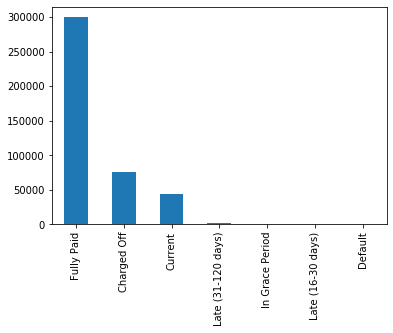

In [19]:
train_data['loan_status'].value_counts().plot(kind='bar')

(array([283173.,      0.,      0.,      0.,      0.,      0.,      0.,
             0.,      0., 137922.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

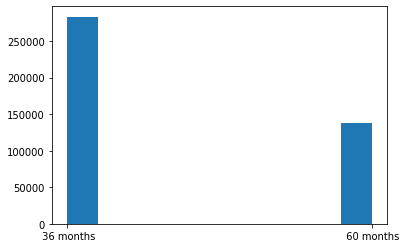

In [20]:
plt.hist(train_data['term'])

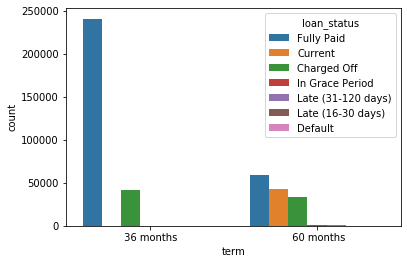

In [21]:
sns.countplot(x='term',hue='loan_status',data=train_data)

Changing columns names for train and test data. removing "_" from column names

In [22]:
cols = []
for col in train_data.columns:
    cols.append(col.replace("_", ""))

In [23]:
train_data.columns=cols

In [24]:
cols = []
for col in test_data.columns:
    cols.append(col.replace("_", ""))

In [25]:
test_data.columns=cols

In [26]:
train_data.notnull().sum()

id                                        421095
memberid                                       0
loanamnt                                  421095
fundedamnt                                421095
fundedamntinv                             421095
term                                      421095
intrate                                   421095
installment                               421095
grade                                     421095
subgrade                                  421095
emptitle                                  397221
emplength                                 397278
homeownership                             421095
annualinc                                 421095
verificationstatus                        421095
issued                                    421095
loanstatus                                421095
pymntplan                                 421095
url                                       421095
desc                                          45
purpose             

Removing columns that are more have 10% Null values

In [27]:
null_columns=train_data.columns[train_data.isnull().mean()>0.1]

In [28]:
train_data.drop(null_columns,axis=1,inplace=True)

/Users/vishalduhan/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [29]:
test_data=test_data[list(train_data.columns)]

In [30]:
train_data.shape

(421095, 91)

In [31]:
test_data.shape

(434407, 91)

Checking if train data and test data has same columns

In [32]:
com_cols = set(train_data.columns) - set(test_data.columns)

In [33]:
com_cols

set()

We only want the data that has reached either default stage or Fully Paid stage.

In [34]:
required_status=["Charged Off","Fully Paid"]
train_data=train_data[train_data["loanstatus"].isin(required_status)]

In [35]:
train_data.shape

(375545, 91)

In [36]:
#test_data_y=test_data[["loanstatus","issued"]]

In [37]:
#test_data.drop(["loanstatus","issued"],axis=1,inplace=True)

In [38]:
train_data.head()

,id,loanamnt,fundedamnt,fundedamntinv,term,intrate,installment,grade,subgrade,emptitle,emplength,homeownership,annualinc,verificationstatus,issued,loanstatus,pymntplan,url,purpose,title,zipcode,addrstate,dti,delinq2yrs,earliestcrline,ficorangelow,ficorangehigh,inqlast6mths,openacc,pubrec,revolbal,revolutil,totalacc,initialliststatus,outprncp,outprncpinv,totalpymnt,totalpymntinv,totalrecprncp,totalrecint,totalreclatefee,recoveries,collectionrecoveryfee,lastpymntd,lastpymntamnt,lastcreditpulld,lastficorangehigh,lastficorangelow,collections12mthsexmed,policycode,applicationtype,accnowdelinq,totcollamt,totcurbal,totalrevhilim,accopenpast24mths,avgcurbal,bcopentobuy,bcutil,chargeoffwithin12mths,delinqamnt,mosinoldilacct,mosinoldrevtlop,mosinrcntrevtlop,mosinrcnttl,mortacc,mthssincerecentbc,numacctsever120pd,numactvbctl,numactvrevtl,numbcsats,numbctl,numiltl,numoprevtl,numrevaccts,numrevtlbalgt0,numsats,numtl120dpd2m,numtl30dpd,numtl90gdpd24m,numtloppast12m,pcttlnvrdlq,percentbcgt75,pubrecbankruptcies,taxliens,tothicredlim,totalbalexmort,totalbclimit,totalilhighcreditlimit,hardshipflag,debtsettlementflag
0,68407277,3600.0,3600.0,3600.0,36 months,13.99,123.03,C,C4,leadman,10+ years,MORTGAGE,55000.0,Not Verified,Dec-2015,Fully Paid,n,https://lendingclub.com/browse/loanDetail.acti...,debt_consolidation,Debt consolidation,190xx,PA,5.91,0.0,Aug-2003,675.0,679.0,1.0,7.0,0.0,2765.0,29.7,13.0,w,0.0,0.0,4421.723917,4421.72,3600.0,821.72,0.0,0.0,0.0,Jan-2019,122.67,Mar-2019,564.0,560.0,0.0,1.0,Individual,0.0,722.0,144904.0,9300.0,4.0,20701.0,1506.0,37.2,0.0,0.0,148.0,128.0,3.0,3.0,1.0,4.0,2.0,2.0,4.0,2.0,5.0,3.0,4.0,9.0,4.0,7.0,0.0,0.0,0.0,3.0,76.9,0.0,0.0,0.0,178050.0,7746.0,2400.0,13734.0,N,N
1,68355089,24700.0,24700.0,24700.0,36 months,11.99,820.28,C,C1,Engineer,10+ years,MORTGAGE,65000.0,Not Verified,Dec-2015,Fully Paid,n,https://lendingclub.com/browse/loanDetail.acti...,small_business,Business,577xx,SD,16.06,1.0,Dec-1999,715.0,719.0,4.0,22.0,0.0,21470.0,19.2,38.0,w,0.0,0.0,25679.660000,25679.66,24700.0,979.66,0.0,0.0,0.0,Jun-2016,926.35,Mar-2019,699.0,695.0,0.0,1.0,Individual,0.0,0.0,204396.0,111800.0,4.0,9733.0,57830.0,27.1,0.0,0.0,113.0,192.0,2.0,2.0,4.0,2.0,0.0,5.0,5.0,13.0,17.0,6.0,20.0,27.0,5.0,22.0,0.0,0.0,0.0,2.0,97.4,7.7,0.0,0.0,314017.0,39475.0,79300.0,24667.0,N,N
2,68341763,20000.0,20000.0,20000.0,60 months,10.78,432.66,B,B4,truck driver,10+ years,MORTGAGE,63000.0,Not Verified,Dec-2015,Fully Paid,n,https://lendingclub.com/browse/loanDetail.acti...,home_improvement,NaN,605xx,IL,10.78,0.0,Aug-2000,695.0,699.0,0.0,6.0,0.0,7869.0,56.2,18.0,w,0.0,0.0,22705.924294,22705.92,20000.0,2705.92,0.0,0.0,0.0,Jun-2017,15813.30,Mar-2019,704.0,700.0,0.0,1.0,Joint App,0.0,0.0,189699.0,14000.0,6.0,31617.0,2737.0,55.9,0.0,0.0,125.0,184.0,14.0,14.0,5.0,101.0,0.0,2.0,3.0,2.0,4.0,6.0,4.0,7.0,3.0,6.0,0.0,0.0,0.0,0.0,100.0,50.0,0.0,0.0,218418.0,18696.0,6200.0,14877.0,N,N
4,68476807,10400.0,10400.0,10400.0,60 months,22.45,289.91,F,F1,Contract Specialist,3 years,MORTGAGE,104433.0,Source Verified,Dec-2015,Fully Paid,n,https://lendingclub.com/browse/loanDetail.acti...,major_purchase,Major purchase,174xx,PA,25.37,1.0,Jun-1998,695.0,699.0,3.0,12.0,0.0,21929.0,64.5,35.0,w,0.0,0.0,11740.500000,11740.50,10400.0,1340.50,0.0,0.0,0.0,Jul-2016,10128.96,Mar-2018,704.0,700.0,0.0,1.0,Individual,0.0,0.0,331730.0,34000.0,10.0,27644.0,4567.0,77.5,0.0,0.0,128.0,210.0,4.0,4.0,6.0,4.0,0.0,4.0,6.0,5.0,9.0,10.0,7.0,19.0,6.0,12.0,0.0,0.0,0.0,4.0,96.6,60.0,0.0,0.0,439570.0,95768.0,20300.0,88097.0,N,N
5,68426831,11950.0,11950.0,11950.0,36 months,13.44,405.18,C,C3,Veterinary Tecnician,4 years,RENT,34000.0,Source Verified,Dec-2015,Fully Paid,n,https://lendingclub.com/browse/loanDetail.acti...,debt_consolidation,Debt consolidation,300xx,GA,10.20,0.0,Oct-1987,690.0,694.0,0.0,5.0,0.0,8822.0,68.4,6.0,w,0.0,0.0,13708.948530,13708.95,11950.0,1758.95,0.0,0.0,0.0,May-2017,7653.56,May-2017,759.0,755.0,0.0,1.0,Individual,0.0,0.0,12798.0,12900.0,0.0,2560.0,844.0,91.0,0.0,0.0,338.0,54.0,32.0,

In [39]:
data_types = train_data.dtypes  
cat_vars = list(data_types[data_types=='object'].index)
num_vars = list(data_types[data_types=='int64'].index) + list(data_types[data_types=='float64'].index)

In [40]:
print ("There are %d categorical features. We will process them one by one." %len(cat_vars))

There are 25 categorical features. We will process them one by one.


In [41]:
print ("There are %d numeric features. We will process them one by one." %len(num_vars))

There are 66 numeric features. We will process them one by one.


In [42]:
cat_vars_plot = ['applicationtype', 'verificationstatus', 'purpose', 'subgrade', 'initialliststatus', 'addrstate', 'grade', 'term',\
                'homeownership', 'emplength']

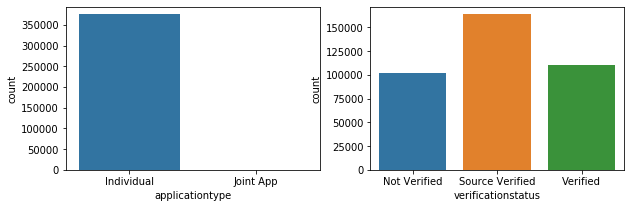

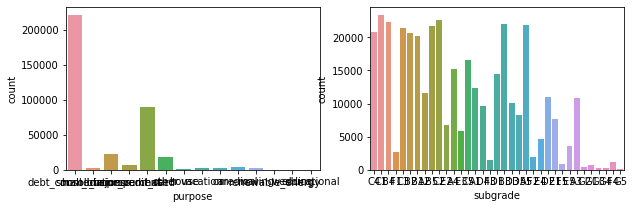

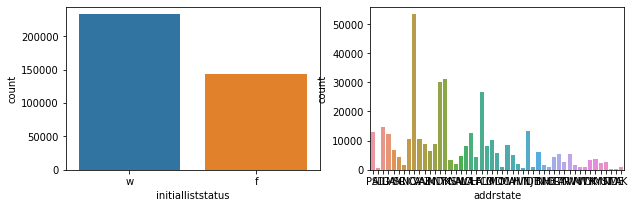

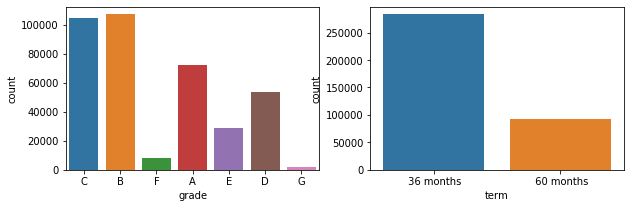

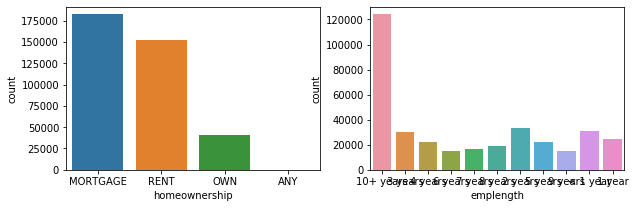

In [43]:
n_cols = 2
n_rows = 5
for i in range(5):
    fg,ax = plt.subplots(nrows=1,ncols=n_cols,figsize=(10, 3))
    for j in range(2):
        g = sns.countplot(x=cat_vars_plot[i*2+j], data=train_data, ax=ax[j])
        g.set_xticklabels(labels=g.get_xticklabels(), rotation = 0)

In [44]:
cat_vars

['id',
 'term',
 'intrate',
 'grade',
 'subgrade',
 'emptitle',
 'emplength',
 'homeownership',
 'verificationstatus',
 'issued',
 'loanstatus',
 'pymntplan',
 'url',
 'purpose',
 'title',
 'zipcode',
 'addrstate',
 'earliestcrline',
 'revolutil',
 'initialliststatus',
 'lastpymntd',
 'lastcreditpulld',
 'applicationtype',
 'hardshipflag',
 'debtsettlementflag']

Dropping more columns that are not insightful for model training

In [45]:
train_drop_columns=['id','pymntplan','url','hardshipflag','debtsettlementflag','lastcreditpulld','lastpymntd']

In [46]:
train_data.drop(train_drop_columns,axis=1,inplace=True)

In [47]:
train_data.shape

(375545, 84)

In [48]:
test_data.drop(train_drop_columns,axis=1,inplace=True)

In [49]:
test_data.shape

(434407, 84)

# Feature engineering

Converting address state column into state frequency

In [50]:
addrstate_freq = pd.DataFrame({'addrstate': train_data["addrstate"].value_counts(normalize = True).index, \
                               'state_freq': train_data["addrstate"].value_counts(normalize = True).values})

In [51]:
train_data = pd.merge(train_data, addrstate_freq, how = 'left', on = 'addrstate')

In [52]:
cat_vars.remove('addrstate')
num_vars.append('state_freq')

Converting zipcode column into zipcode frequency column

In [53]:
train_data["zipcode"] = train_data["zipcode"].apply(lambda x: int(x.strip('xx')))

In [54]:
zipcode_freq = pd.DataFrame({'zipcode': train_data["zipcode"].value_counts(normalize = True).index, \
                               'zipcode_freq': train_data["zipcode"].value_counts(normalize = True).values})

In [55]:
train_data = pd.merge(train_data, zipcode_freq, how = 'left', on = 'zipcode')

In [56]:
cat_vars.remove('zipcode')
num_vars.append('zipcode')
num_vars.append('zipcode_freq')

In [57]:
train_data["applicationtype"].value_counts()

Individual    375144
Joint App        401
Name: applicationtype, dtype: int64

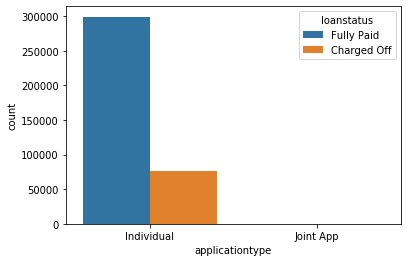

In [58]:
sns.countplot(x="applicationtype",hue="loanstatus",data=train_data)

In [59]:
train_data.drop("applicationtype",inplace=True,axis=1)

Converting earliestline to credit_hitory

In [60]:
earliest_crl = train_data['earliestcrline'].apply(lambda x: dt.datetime.strptime(str(x), '%b-%Y'))

In [61]:
train_data['credit_history'] = earliest_crl.apply(lambda x: (dt.date(2019, 1, 1) - x.date()).days)

In [62]:
cat_vars.remove('earliestcrline')
num_vars.append('credit_hist')

Column emplength

In [63]:
train_data["emplength"].value_counts()

10+ years    123990
2 years       33758
< 1 year      30938
3 years       30031
1 year        24885
5 years       22344
4 years       22034
8 years       19257
7 years       16423
6 years       15000
9 years       14827
Name: emplength, dtype: int64

In [64]:
train_data["emplength"].isnull().sum()

22058

In [65]:
train_data['emplength'].replace('NaN', np.nan, inplace = True)

In [66]:
train_data['emplength'].replace('< 1 year', '0', inplace = True)

In [67]:
train_data['emplength'].replace('10+ years', '10', inplace = True)

In [68]:
train_data['emplength'].replace(to_replace='[^0-9]+', value = '', inplace= True, regex= True)

In [69]:
train_data['emplength']=train_data['emplength'][train_data['emplength'].notnull()].astype(int).apply(lambda x: x*12)

In [70]:
train_data["emplength"].value_counts()

120.0    123990
24.0      33758
0.0       30938
36.0      30031
12.0      24885
60.0      22344
48.0      22034
96.0      19257
84.0      16423
72.0      15000
108.0     14827
Name: emplength, dtype: int64

In [71]:
train_data['emplength'].fillna(-500,inplace=True)

In [72]:
cat_vars.remove('emplength')
num_vars.append('emplength')

Column emptitle: only few titles have significance on result

In [73]:
train_data["emptitle"].value_counts()

Teacher                          7010
Manager                          6101
Owner                            3416
Registered Nurse                 2828
RN                               2776
                                 ... 
Psychiatric Care Manager            1
Associate Dean of the College       1
Desktop Admin                       1
Caller                              1
line mechanic 2                     1
Name: emptitle, Length: 109810, dtype: int64

In [74]:
train_data['emptitle'] = train_data['emptitle'].astype('str').apply(lambda x: x.lower())

In [75]:
train_data['emptitle'].replace('nan', np.nan, inplace = True)

In [76]:
ishigherclass = train_data['emptitle'].str.contains('manager|president|officer|supervisor|director|excutive|owner')

In [77]:
#ishigherclass.fillna(False, inplace= True)

In [78]:
ishigherclass.value_counts()

False    249838
True     103604
Name: emptitle, dtype: int64

In [79]:
ishigherclass.isnull().sum()

22103

In [80]:
isnothigherclass = (ishigherclass == False)

In [81]:
ishigherclass.fillna(False,inplace=True)

In [82]:
train_data['emptitle'].fillna(-500,inplace=True)
train_data['emptitle'][isnothigherclass]=0
train_data['emptitle'][ishigherclass]=1


/Users/vishalduhan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/vishalduhan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [83]:
train_data["emptitle"].value_counts()

 0      249838
 1      103604
-500     22103
Name: emptitle, dtype: int64

In [84]:
cat_vars.remove('emptitle')

Grade

In [85]:
train_data['grade'] = train_data['grade'].replace({'A': 1, 'B': 2, 'C': 3, 'D': 4, 'E': 5, 'F': 6, 'G': 7})

In [86]:
cat_vars.remove('grade')
num_vars.append('grade')

Homeownership: Creating dummy variables

In [87]:
train_data['homeownership'].value_counts()

MORTGAGE    182130
RENT        152342
OWN          41071
ANY              2
Name: homeownership, dtype: int64

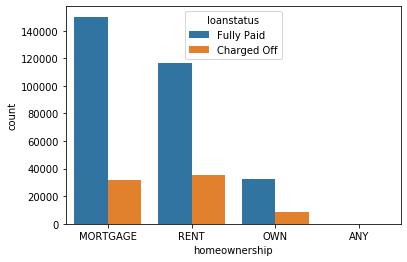

In [88]:
sns.countplot(x='homeownership',data=train_data,hue='loanstatus')

In [89]:
train_data=pd.get_dummies(train_data,columns=["homeownership"])

In [90]:
cat_vars.remove('homeownership')

In [91]:
train_data['initialliststatus'].value_counts()

w    232558
f    142987
Name: initialliststatus, dtype: int64

In [92]:
train_data['initialliststatus']=train_data['initialliststatus'].replace({'w':0,"f":1})

In [93]:
cat_vars.remove('initialliststatus')
num_vars.append('initialliststatus')

In [94]:
cat_vars.remove('intrate')
num_vars.append('intrate')

Verification status: Creating dummy variables

In [95]:
train_data["verificationstatus"].value_counts()

Source Verified    163548
Verified           110346
Not Verified       101651
Name: verificationstatus, dtype: int64

In [96]:
train_data["verificationstatus"].replace(['Not Verified', 'Source Verified', 'Verified'], ['NOT_VERIFIED', 'SOURCE_VERIFIED', 'VERIFIED'],\
                          inplace= True)

In [97]:
train_data=pd.get_dummies(train_data,columns=["verificationstatus"])

In [98]:
cat_vars.remove('verificationstatus')

Purpose: creating dummy

In [99]:
train_data["purpose"].value_counts()

debt_consolidation    222050
credit_card            90092
home_improvement       22707
other                  17944
major_purchase          6730
medical                 3684
car                     3203
small_business          3081
moving                  2313
vacation                2191
house                   1331
renewable_energy         214
wedding                    4
educational                1
Name: purpose, dtype: int64

In [100]:
train_data=pd.get_dummies(train_data,columns=["purpose"])

In [101]:
cat_vars.remove('purpose')

Subgrade: Replacing string to numeric

In [102]:
temp3=train_data["subgrade"].sort_values().unique()

In [103]:
train_data["subgrade"]=train_data["subgrade"].replace({temp3[i]:i+1 for i in range(len(temp3))})

In [104]:
cat_vars.remove('subgrade')
num_vars.append('subgrade')

Term converting string to numeric

In [105]:
train_data["term"].sort_values().unique()

array([' 36 months', ' 60 months'], dtype=object)

In [106]:
train_data["term"]=train_data["term"].map({' 36 months':36,' 60 months':60})

In [107]:
train_data["term"].value_counts()

36    283026
60     92519
Name: term, dtype: int64

In [108]:
cat_vars.remove('term')
num_vars.append('term')

Revolutil: filling null values

In [109]:
train_data['revolutil'].mean()

53.11258288024881

In [110]:
train_data['revolutil'].fillna(train_data['revolutil'].mean(),inplace=True)

In [111]:
train_data['revolutil'].isnull().sum()

0

loanstatus: converting string to numeric

In [112]:
train_data['loanstatus']=train_data['loanstatus'].replace({'Fully Paid':0,"Charged Off":1})

In [113]:
train_data.shape

(375545, 104)

dti: filling null values, cutting data to 5 bins

In [114]:
train_data['dti'].describe()

count    375543.000000
mean         18.942635
std           8.887976
min           0.000000
25%          12.390000
50%          18.380000
75%          25.100000
max         999.000000
Name: dti, dtype: float64

In [115]:
train_data=train_data[train_data["dti"].notnull()]

In [116]:
train_data.dti.isnull().sum()

0

In [117]:
train_data['dti'].mean()

18.942634505236946

In [118]:
train_data['dti'].fillna(18.94,inplace=True)

In [119]:
train_data['dti'] = pd.cut(train_data['dti'],bins=[-1.00, 8.00, 16.00, 24.00, \
                                                           32.00, max(train_data.dti)],labels=["a1", "a2", "a3",'a4','a5'])

In [120]:
train_data["dti"].isnull().sum()

0

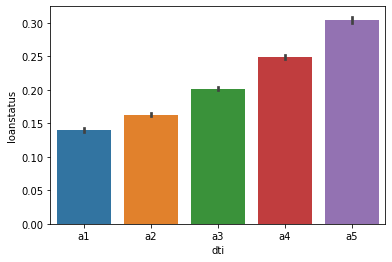

In [121]:
sns.barplot(x='dti', y= 'loanstatus', data = train_data)

annualinc: cutting data to bins

In [122]:
train_data.annualinc.describe()

count    3.755430e+05
mean     7.626962e+04
std      7.499088e+04
min      1.200000e+03
25%      4.500000e+04
50%      6.500000e+04
75%      9.000000e+04
max      9.500000e+06
Name: annualinc, dtype: float64

In [123]:
train_data['annualinc'] = pd.cut(train_data.annualinc, bins=[0, 25001, 50001, 75001, \
                                                           100001, 125001, 150001, \
                                                           175001, 200001, max(train_data.annualinc)+1],labels=["b1", "b2", "b3",'b4','b5','b6','b7','b8','b9'])

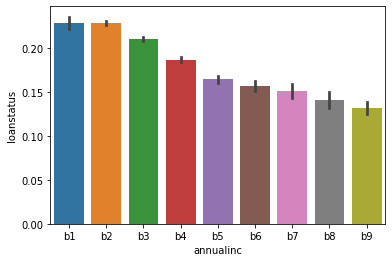

In [124]:
sns.barplot(x='annualinc',y='loanstatus',data=train_data)

interest rate: cutting data to bins

In [125]:
train_data.intrate.sort_values()

40563      5.32
198881     5.32
87476      5.32
239119     5.32
198889     5.32
          ...  
134238    28.99
13650     28.99
168667    28.99
119134    28.99
193721    28.99
Name: intrate, Length: 375543, dtype: object

In [126]:
train_data['intrate'] = pd.cut(train_data.intrate, bins=[min(train_data.intrate)-1, 8.01, 12.01, 16.01, \
                                                           20.01, 24.01, max(train_data.intrate)+1],labels=["c1", "c2", "c3",'c4','c5','c6'])

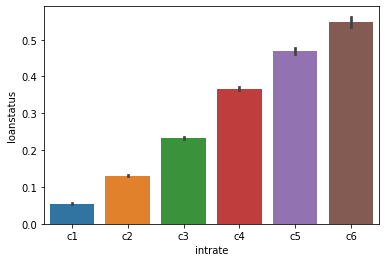

In [127]:
sns.barplot(x='intrate',y='loanstatus',data=train_data)

Bcutil: filling null values and cutting data to bins

In [128]:
train_data.bcutil.describe()

count    371682.000000
mean         61.540929
std          27.719596
min           0.000000
25%          40.600000
50%          64.900000
75%          85.900000
max         318.200000
Name: bcutil, dtype: float64

In [129]:
train_data['bcutil'].isnull().sum()

3861

In [130]:
train_data["bcutil"].fillna(64,inplace=True)

In [131]:
train_data['bcutil'] = pd.cut(train_data.bcutil, bins=[min(train_data.bcutil)-1, 34.01, 64.01, 100.01, \
                                                           138.01, max(train_data.bcutil)+1],labels=["d1", "d2", "d3",'d4','d5'])

In [132]:
train_data['bcutil'].isnull().sum()

0

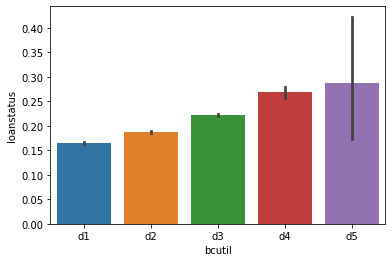

In [133]:
sns.barplot(x='bcutil',y='loanstatus',data=train_data)

In [134]:
train_data.credit_history.describe()

count    375543.000000
mean       7364.229481
std        2780.200745
min        2252.000000
25%        5448.000000
50%        6788.000000
75%        8797.000000
max       27394.000000
Name: credit_history, dtype: float64

In [135]:
train_data.credit_history.sort_values()

21795      2252
4736       2252
25229      2252
11978      2252
3385       2252
          ...  
300369    24990
294847    24990
179771    25202
22589     25202
366465    27394
Name: credit_history, Length: 375543, dtype: int64

In [136]:
train_data['credit_history'] = pd.cut(train_data.credit_history, bins=[min(train_data.credit_history)-1, 5000, 8000, 12000, \
                                                            max(train_data.credit_history)+1],labels=["e1", "e2", "e3",'e4'])

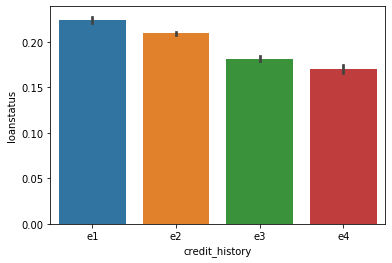

In [137]:
sns.barplot(x='credit_history',y='loanstatus',data=train_data)

In [138]:
train_data.shape

(375543, 104)

In [139]:
train_data.drop("title",axis=1,inplace=True)

# test data

We are applying same transformation for test data that we did for train data.

In [140]:
test_data.drop("title",axis=1,inplace=True)

In [141]:
required_status=["Charged Off","Fully Paid"]
test_data=test_data[test_data["loanstatus"].isin(required_status)]

In [142]:
addrstate_freq = pd.DataFrame({'addrstate': test_data["addrstate"].value_counts(normalize = True).index, \
                               'state_freq': test_data["addrstate"].value_counts(normalize = True).values})

test_data = pd.merge(test_data, addrstate_freq, how = 'left', on = 'addrstate')

In [143]:
test_data["zipcode"] = test_data["zipcode"].apply(lambda x: int(x.strip('xx')))

zipcode_freq = pd.DataFrame({'zipcode': test_data["zipcode"].value_counts(normalize = True).index, \
                               'zipcode_freq': test_data["zipcode"].value_counts(normalize = True).values})

test_data = pd.merge(test_data, zipcode_freq, how = 'left', on = 'zipcode')

In [144]:
test_data.drop("applicationtype",inplace=True,axis=1)

earliest_crl = test_data['earliestcrline'].apply(lambda x: dt.datetime.strptime(str(x), '%b-%Y'))

test_data['credit_history'] = earliest_crl.apply(lambda x: (dt.date(2019, 1, 1) - x.date()).days)

In [145]:
test_data['emplength'].replace('NaN', np.nan, inplace = True)

test_data['emplength'].replace('< 1 year', '0', inplace = True)

test_data['emplength'].replace('10+ years', '10', inplace = True)

test_data['emplength'].replace(to_replace='[^0-9]+', value = '', inplace= True, regex= True)

test_data['emplength']=test_data['emplength'][test_data['emplength'].notnull()].astype(int).apply(lambda x: x*12)

In [146]:
test_data['emplength'].fillna(-500,inplace=True)

In [147]:
test_data['emptitle'] = test_data['emptitle'].astype('str').apply(lambda x: x.lower())

test_data['emptitle'].replace('nan', np.nan, inplace = True)



ishigherclass = test_data['emptitle'].str.contains('manager|president|officer|supervisor|director|excutive|owner')

#ishigherclass.fillna(False, inplace= True)

ishigherclass.value_counts()

ishigherclass.isnull().sum()

isnothigherclass = (ishigherclass == False)

ishigherclass.fillna(False,inplace=True)

test_data['emptitle'].fillna(-500,inplace=True)
test_data['emptitle'][isnothigherclass]=0
test_data['emptitle'][ishigherclass]=1


/Users/vishalduhan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/vishalduhan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [148]:
test_data['grade'] = test_data['grade'].replace({'A': 1, 'B': 2, 'C': 3, 'D': 4, 'E': 5, 'F': 6, 'G': 7})

In [149]:
test_data["homeownership"].value_counts()

MORTGAGE    142800
RENT        114602
OWN          35630
ANY             63
Name: homeownership, dtype: int64

In [150]:
test_data=pd.get_dummies(test_data,columns=["homeownership"])

In [151]:
test_data['initialliststatus']=test_data['initialliststatus'].replace({'w':0,"f":1})

In [152]:
test_data["verificationstatus"].replace(['Not Verified', 'Source Verified', 'Verified'], ['NOT_VERIFIED', 'SOURCE_VERIFIED', 'VERIFIED'],\
                          inplace= True)

test_data=pd.get_dummies(test_data,columns=["verificationstatus"])

In [153]:
test_data=pd.get_dummies(test_data,columns=["purpose"])

In [154]:
temp3=test_data["subgrade"].sort_values().unique()

test_data["subgrade"]=test_data["subgrade"].replace({temp3[i]:i+1 for i in range(len(temp3))})

In [155]:
test_data["term"]=test_data["term"].map({' 36 months':36,' 60 months':60})

In [156]:
test_data['revolutil'].fillna(50,inplace=True)

In [157]:


test_data['loanstatus']=test_data['loanstatus'].replace({'Fully Paid':0,"Charged Off":1})

In [158]:
test_data['dti'].describe()

count    293057.000000
mean         18.793805
std          10.608179
min          -1.000000
25%          12.180000
50%          18.130000
75%          24.820000
max         999.000000
Name: dti, dtype: float64

In [159]:
test_data['dti'].isnull().sum()

38

In [160]:
test_data["dti"].fillna(18.79,inplace=True)

In [161]:
test_data['dti'].fillna(test_data['dti'].mean(),inplace=True)

test_data['dti'] = pd.cut(test_data['dti'],bins=[min(test_data.dti)-1, 8.01, 16.01, 24.01, \
                                                           32.01, max(test_data.dti)+1],labels=["a1", "a2", "a3",'a4','a5'])

In [162]:
test_data['dti'].isnull().sum()

0

In [163]:
test_data.annualinc.describe()

count    2.930950e+05
mean     7.877739e+04
std      7.762752e+04
min      0.000000e+00
25%      4.800000e+04
50%      6.600000e+04
75%      9.400000e+04
max      9.550000e+06
Name: annualinc, dtype: float64

In [164]:
test_data.annualinc.isnull().sum()

0

In [165]:
test_data['annualinc'] = pd.cut(test_data.annualinc, bins=[-1, 25001, 50001, 75001, \
                                                           100001, 125001, 150001, \
                                                           175001, 200001, max(test_data.annualinc)+1],labels=["b1", "b2", "b3",'b4','b5','b6','b7','b8','b9'])

In [166]:
test_data.annualinc.isnull().sum()

0

In [167]:
test_data.intrate=test_data.intrate.astype(float)

In [168]:
test_data.intrate.describe()

count    293095.000000
mean         13.086578
std           5.041227
min           5.320000
25%           9.170000
50%          11.990000
75%          15.590000
max          30.990000
Name: intrate, dtype: float64

In [169]:
test_data.intrate.isnull().sum()

0

In [170]:
test_data['intrate'] = pd.cut(test_data.intrate, bins=[min(test_data.intrate)-1, 8.01, 12.01, 16.01, \
                                                           20.01, 24.01, max(test_data.intrate)+1],labels=["c1", "c2", "c3",'c4','c5','c6'])

In [171]:
test_data.intrate.isnull().sum()

0

In [172]:
test_data.bcutil.describe()

count    289735.000000
mean         57.360476
std          28.429214
min           0.000000
25%          35.100000
50%          59.100000
75%          82.300000
max         201.900000
Name: bcutil, dtype: float64

In [173]:
test_data.bcutil.isnull().sum()

3360

In [174]:
test_data.bcutil.fillna(57.3,inplace=True)

In [175]:
test_data.bcutil.isnull().sum()

0

In [176]:
test_data['bcutil'] = pd.cut(test_data.bcutil, bins=[min(test_data.bcutil)-1, 35.01, 70.01, 105.01, \
                                                           140.01, max(test_data.bcutil)+1],labels=["d1", "d2", "d3",'d4','d5'])

In [177]:
test_data.bcutil.isnull().sum()

0

In [178]:
test_data.credit_history.isnull().sum()

0

In [179]:
test_data['credit_history'] = pd.cut(test_data.credit_history, bins=[min(test_data.credit_history)-1, 5000, 8000, 12000, \
                                                            max(test_data.credit_history)+1],labels=["e1", "e2", "e3",'e4'])

In [180]:
test_data.shape

(293095, 102)

In [181]:
test_data=test_data[test_data['inqlast6mths'].notnull()]

In [182]:
test_data["purpose_educational"]=0

In [183]:
train_data=train_data[train_data['numrevaccts'].notnull()]

In [184]:
listdrop=["percentbcgt75","numtl120dpd2m","mthssincerecentbc","mosinoldilacct","bcopentobuy"]

In [185]:
train_data.drop(listdrop,axis=1,inplace=True)

In [186]:
test_data.drop(listdrop,axis=1,inplace=True)

In [187]:
train_data_y=train_data[["loanstatus"]]

In [188]:
test_data_y=test_data[["loanstatus"]]

In [189]:
train_data.drop(["loanstatus","issued","earliestcrline","addrstate"],axis=1,inplace=True)

In [190]:
test_data.drop(["loanstatus","issued","earliestcrline","addrstate"],axis=1,inplace=True)

In [191]:
train_data=pd.get_dummies(train_data,columns=["intrate",'annualinc','dti','bcutil','credit_history'])

In [192]:
test_data=pd.get_dummies(test_data,columns=["intrate",'annualinc','dti','bcutil','credit_history'])

In [193]:
train_data.shape

(375542, 118)

In [194]:
test_data.shape

(293094, 118)

In [195]:
train_data.isnull().sum()

loanamnt                              0
fundedamnt                            0
fundedamntinv                         0
term                                  0
installment                           0
grade                                 0
subgrade                              0
emptitle                              0
emplength                             0
zipcode                               0
delinq2yrs                            0
ficorangelow                          0
ficorangehigh                         0
inqlast6mths                          0
openacc                               0
pubrec                                0
revolbal                              0
revolutil                             0
totalacc                              0
initialliststatus                     0
outprncp                              0
outprncpinv                           0
totalpymnt                            0
totalpymntinv                         0
totalrecprncp                         0


In [196]:
train_data["emptitle"]=train_data["emptitle"].apply(lambda x: int(x))
test_data["emptitle"]=test_data["emptitle"].apply(lambda x: int(x))
test_data["revolutil"]=test_data["revolutil"].apply(lambda x: float(x))

# Training model

First model is trained on Standard Random forest Classifier, to observe the impact of feature engineering and to set the benchmark for further model training.

In [236]:
model=RandomForestClassifier()

In [203]:
model.fit(train_data,train_data_y)

/Users/vishalduhan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  """Entry point for launching an IPython kernel.


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [204]:
y_pred=model.predict(test_data)

In [206]:
accuracy_score(test_data_y,y_pred)

0.9966734221785503

Accuracy of 99.66% IS ACHIEVED ON RANDOM FOREST.

FROM HERE MODEL IS TRAINED ON XGBOOST AND TUNING IS DONE WITH BAYESIAN OPTIMIZATION.

In [208]:
dtrain = xgb.DMatrix(train_data, train_data_y, missing= np.nan)
dtest = xgb.DMatrix(test_data, missing= np.nan)

In [209]:
def xgb_evaluate(min_child_weight,
                 colsample_bytree,
                 max_depth,
                 subsample,
                 gamma):
    params = dict()
    params['objective'] = 'binary:logistic'
    params['eta'] = 0.1
    params['max_depth'] = int(max_depth)   
    params['min_child_weight'] = int(min_child_weight)
    params['colsample_bytree'] = colsample_bytree
    params['subsample'] = subsample
    params['gamma'] = gamma
    params['verbose_eval'] = True    


    cv_result = xgb.cv(params, dtrain,
                       num_boost_round=10000,
                       nfold=5,
                       metrics={'auc'},
                       seed=1234,
                       stratified=True,
                       callbacks=[xgb.callback.early_stop(30)])

    return cv_result['test-auc-mean'].max()

In [210]:
xgb_BO = BayesianOptimization(xgb_evaluate, 
                             {'max_depth': (3, 9),
                              'min_child_weight': (0, 80),
                              'colsample_bytree': (0.5, 1),
                              'subsample': (0.5, 1),
                              'gamma': (0, 2)
                             }
                            )

In above cell, provided some parametres ranges to xgb cross validation to train model on. with boost rounds equal to
10000, and if no improvement in consecutive 30 rounds then it calls for a stop, metrics chosed here is area under curve.

In [211]:
%%time
xgb_BO.maximize(init_points=4, n_iter=3)

|   iter    |  target   | colsam... |   gamma   | max_depth | min_ch... | subsample |
-------------------------------------------------------------------------------------
Multiple eval metrics have been passed: 'test-auc' will be used for early stopping.

Will train until test-auc hasn't improved in 30 rounds.
Stopping. Best iteration:
[845]	train-auc:0.99994+0.00000	test-auc:0.99990+0.00004

|  1        |  0.9999   |  0.7211   |  0.3845   |  3.071    |  73.37    |  0.8953   |
Multiple eval metrics have been passed: 'test-auc' will be used for early stopping.

Will train until test-auc hasn't improved in 30 rounds.
Stopping. Best iteration:
[589]	train-auc:0.99994+0.00000	test-auc:0.99989+0.00004

|  2        |  0.9999   |  0.885    |  0.1691   |  3.024    |  45.87    |  0.608    |
Multiple eval metrics have been passed: 'test-auc' will be used for early stopping.

Will train until test-auc hasn't improved in 30 rounds.
Stopping. Best iteration:
[486]	train-auc:0.99995+0.00000	test-au

best value of parametres is found here and it is stored in a dataframe.

In [212]:
scores = pd.DataFrame(x['params'] for x in xgb_BO.res)
scores['target'] = pd.DataFrame(x['target'] for x in xgb_BO.res)
scores = scores.sort_values(by='target',ascending=False).reset_index()
scores.head()

,index,colsample_bytree,gamma,max_depth,min_child_weight,subsample,target
0,5,0.817535,0.894718,8.999993,0.050753,0.596843,0.999935
1,4,0.937097,1.042494,3.730755,0.026539,0.971642,0.999934
2,3,0.754897,0.394922,8.808501,28.325571,0.899136,0.999929
3,2,0.789522,1.690155,8.202218,79.853970,0.993487,0.999899
4,0,0.721072,0.384520,3.070985,73.369430,0.895315,0.999898


In [213]:
best_params = dict()

best_params['max_depth'] = int(scores['max_depth'][0])
best_params['min_child_weight'] = int(scores['min_child_weight'][0])
best_params['colsample_bytree'] = scores['colsample_bytree'][0]
best_params['subsample'] = scores['subsample'][0]
best_params['gamma'] = scores['gamma'][0]

best_params['objective'] = 'binary:logistic'
best_params['eta'] = 0.02
best_params['seed'] = 1234

In [214]:
best_params

{'max_depth': 8,
 'min_child_weight': 0,
 'colsample_bytree': 0.8175346819990771,
 'subsample': 0.5968425421287629,
 'gamma': 0.8947179223971773,
 'objective': 'binary:logistic',
 'eta': 0.02,
 'seed': 1234}

In cell below, best iteration is found for the data.

In [215]:
cv_result = xgb.cv(best_params, dtrain,
                   num_boost_round=15000,
                   nfold=5,
                   metrics={'auc'},
                   seed=1234,
                   stratified=True,
                   callbacks=[xgb.callback.early_stop(200)],
                   verbose_eval=50)


best_iteration = len(cv_result)
best_score = cv_result['test-auc-mean'].max()
print("Best score %f, best iteration %d" % (best_score,best_iteration) )

Multiple eval metrics have been passed: 'test-auc' will be used for early stopping.

Will train until test-auc hasn't improved in 200 rounds.
[0]	train-auc:0.99116+0.00040	test-auc:0.99083+0.00083
[50]	train-auc:0.99911+0.00009	test-auc:0.99899+0.00031
[100]	train-auc:0.99943+0.00009	test-auc:0.99930+0.00014
[150]	train-auc:0.99971+0.00002	test-auc:0.99958+0.00013
[200]	train-auc:0.99984+0.00002	test-auc:0.99972+0.00008
[250]	train-auc:0.99989+0.00002	test-auc:0.99975+0.00008
[300]	train-auc:0.99992+0.00001	test-auc:0.99977+0.00007
[350]	train-auc:0.99996+0.00001	test-auc:0.99980+0.00006
[400]	train-auc:0.99998+0.00000	test-auc:0.99984+0.00006
[450]	train-auc:0.99998+0.00000	test-auc:0.99987+0.00005
[500]	train-auc:0.99999+0.00000	test-auc:0.99989+0.00004
[550]	train-auc:0.99999+0.00000	test-auc:0.99990+0.00004
[600]	train-auc:1.00000+0.00000	test-auc:0.99991+0.00004
[650]	train-auc:1.00000+0.00000	test-auc:0.99992+0.00004
[700]	train-auc:1.00000+0.00000	test-auc:0.99992+0.00004
[750]	

Now, data is trained using best paramentres values, best iteration.

In [216]:
gbm = xgb.train(best_params, dtrain, num_boost_round=best_iteration)

In [217]:
dtest.feature_names=dtrain.feature_names

outputs for test data is predicted on trained model.

In [218]:
y_pred = gbm.predict(dtest)

In [672]:
pickle.dump(gbm, open("trainedmodel.dat", "wb"))

ROC curve and AUC is plotted here.

In [223]:
x_t, x_cv, y_t, y_cv = train_test_split(train_data, train_data_y, test_size = 0.3, \
                                    random_state = 1234, stratify = train_data_y)

In [224]:
def draw_ROC (model, traindata, cvdata, testdata, trainy, cvy, testy):
    prob_0 = model.predict(traindata)
    prob_1 = model.predict(cvdata)
    prob_2 = model.predict(testdata)
    fpr_0, tpr_0, thresholds_0 = roc_curve(trainy, prob_0)
    fpr_1, tpr_1, thresholds_1 = roc_curve(cvy, prob_1)
    fpr_2, tpr_2, thresholds_2 = roc_curve(testy, prob_2)
    roc_auc_0 = auc(fpr_0, tpr_0)
    roc_auc_1 = auc(fpr_1, tpr_1)
    roc_auc_2 = auc(fpr_2, tpr_2)
    
    print ("Area under the ROC Curve - Train: %f" %(roc_auc_0))
    print ("Area under the ROC Curve - Validation: %f" % (roc_auc_1))
    print ("Area under the ROC Curve - Test: %f" % (roc_auc_2))
    
    Youdens_0 = tpr_0 - fpr_0
    Youdens_1 = tpr_1 - fpr_1
    Youdens_2 = tpr_2 - fpr_2
    
    #Plot ROC Curve
    plt.figure(figsize = (8,8))
    plt.plot(fpr_0, tpr_0, label = 'ROC Curve - Train (AUC = %0.2f)' % (roc_auc_0), color= 'r')
    plt.plot(fpr_1, tpr_1, label = 'ROC Curve - Validation (AUC = %0.2f)' % (roc_auc_1), color= 'b')
    plt.plot(fpr_2, tpr_2, label = 'ROC Curve - Test (AUC = %0.2f)' % (roc_auc_2), color= 'g')
    plt.plot([0,1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC for lead score model')
    plt.legend(loc='lower right')
    plt.show()
    
    return (Youdens_0, thresholds_0, Youdens_1, thresholds_1, Youdens_2, thresholds_2)

In [225]:
x_t_xgb = xgb.DMatrix(x_t, missing= np.nan)
x_cv_xgb = xgb.DMatrix(x_cv, missing= np.nan)

Area under the ROC Curve - Train: 1.000000
Area under the ROC Curve - Validation: 1.000000
Area under the ROC Curve - Test: 0.999949


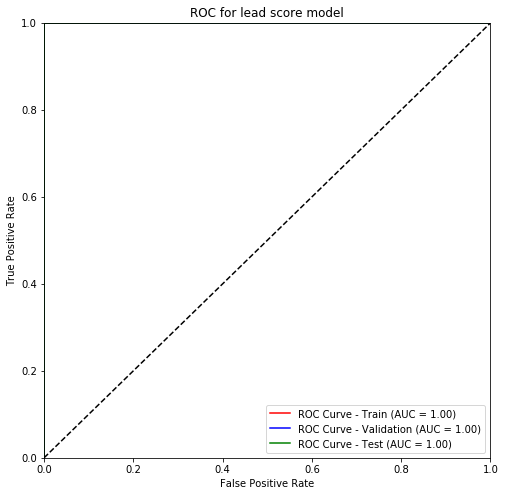

In [226]:
Youdens_0, thresholds_0, Youdens_1, thresholds_1, Youdens_2, thresholds_2 = \
draw_ROC(gbm, x_t_xgb, x_cv_xgb, dtest, y_t, y_cv, test_data_y)

Here , threshold is found to be near 0.5 as Youden index is max at 0.5.

Text(0, 0.5, "Youden's Index")

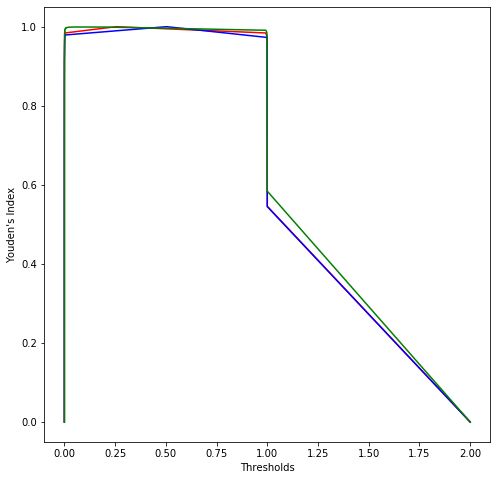

In [227]:
plt.figure(figsize = (8,8))
plt.plot(thresholds_0, Youdens_0, label = "Youden's Index - Train", color= 'r')
plt.plot(thresholds_1, Youdens_1, label = "Youden's Index - Validation", color= 'b')
plt.plot(thresholds_2, Youdens_2, label = "Youden's Index - Test", color= 'g')
plt.xlabel('Thresholds')
plt.ylabel("Youden's Index")

In [228]:
t=y_pred.copy()

Comparing every predicted value with 0.5 as 0.5 is our threshold.

In [230]:
z=[]
for x in t:
    if x<=0.5:
        z.append(0)
    else:
        z.append(1)

In [231]:
accuracy_score(test_data_y,z)

0.9996963431527087

Accuracy with Xgboost seems to over-perform Random Forest as accuracy_xgboost - accuracy_rf=0.00302

In [233]:
cm = confusion_matrix(test_data_y, z)

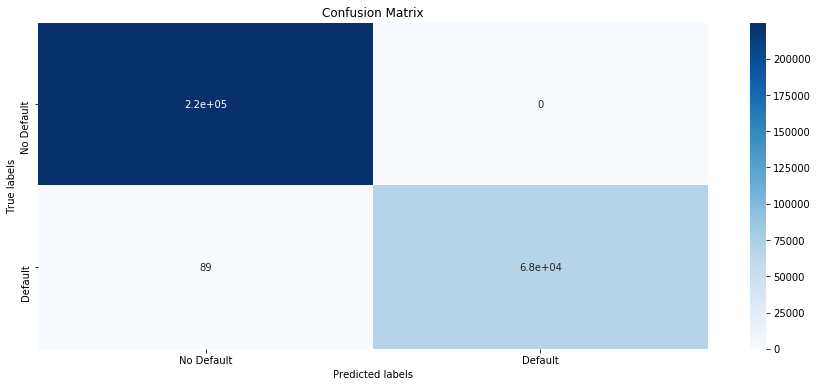

In [234]:
plt.figure(figsize=(15, 6))
ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax,cmap="Blues"); 
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['No Default', 'Default']); ax.yaxis.set_ticklabels(['No Default', 'Default']);

This methodology can be used to assist investor with their decision of investment on Lending Club. This model predicts the outputs of whether a certain profile is going to default or not using historic data. In this program I have used data of 2015 year as train data and data of 2016 year as test data to build a Machine Learning model. And, acquired a whopping accuracy of more than 99%.